In [1]:
import os
import pandas as pd
import geopandas as gpd
import xarray as xr
import math
import rasterio
from rasterio.merge import merge
from rasterio.io import MemoryFile
import numpy as np
from rasterio.io import MemoryFile
from rasterio.windows import Window

**Build ML models to predict fire ignition for a pixel**

Features: FWI, lat, lon, elevation, landcover (2010), distance, month
Label: ignited or not ignited
Model: XGBoost
Optimization Method: Beyas optimization using Optuna
Data range: EU

Steps:
1. Merge positive and negative labels of fire intensity and FWi data
    1.1 Load left join data (fire intensity left join FWI, resolution 1km) and count how many data points it has
    1.2 Assign positive labels (ignited) to the data points with distance <= 31 * sqrt(2) / 2 and only keep rows with positive labels
    1.3 Load right join data (fire intensity right join FWI, resolution 31km) and count how may data points it has
    1.4 Down sampling the data to match the number of left join data
    1.5 Assign negative labels (ignited) to the data points with distance > 31 * sqrt(2) / 2 and only keep rows with negative labels
    1.6 Merge data and save the geo dataframe and save the dataframe
2. Add land cover (aggregated) data to pixel according to lon and lat
    2.1 Load land cover shapefile and convert to geopandas dataframe
    2.2 for each pixel (1x1 for left and 31x31 for right), calculate the average probability of fire ignition according to Clamada Master thesis Table 2.1
3. Add elevation data to pixel according to lon and lat
    3.1 Load elevation shapefile and convert to geopandas dataframe
    3.2 for each pixel (1x1 for left and 31x31 for right), calculate the average elevation
4. Build ML models to predict whether a pixel is ignited
5. Tune hyperparameters

Issue solved:

1. Longitude range in right joined dataset was not correct. Now correct after rerun the code.
2. If the lon and lat can't be find in the elevation data raster, it will be converted to indices outside the raster. Now it will be converted to the nearest valid elevation.

# 1. Merge positive and negative labels of fire intensity and FWi data

In [2]:
from geopy.distance import great_circle

# Define a function to calculate the distance
def calculate_distance(row):
    coords_1 = (row['latitude_left'], row['longitude_left'])
    coords_2 = (row['latitude_right'], row['longitude_right'])
    return great_circle(coords_1, coords_2).kilometers

folder = '../../climada_petals/data/wildfire/output/2013/'

## 1.1 Load left join data (fire intensity left join FWI, resolution 1km)

In [19]:
merged_eu_2013_left_gdf_filename = 'merged_eu_2013_left_gdf'
df_left_join = gpd.read_file(os.path.join(folder, merged_eu_2013_left_gdf_filename))
df_left_join.shape

(78382, 17)

In [20]:
# Apply the function to each row in the GeoDataFrame and create a new column 'distance_km'
df_left_join['distance_km'] = df_left_join.apply(calculate_distance, axis=1)

In [21]:
df_left_join['distance_km'].describe()

count    78382.000000
mean         9.123286
std          3.588911
min          0.035163
25%          6.526173
50%          9.238830
75%         12.049334
max         17.695499
Name: distance_km, dtype: float64

In [22]:
df_left_join['longitude_left'].describe()

count    78382.000000
mean        22.953229
std         14.650091
min        -29.313700
25%         13.488950
50%         27.629200
75%         35.057125
max         39.999500
Name: longitude_left, dtype: float64

In [23]:
df_left_join

,latitude_left,longitude_left,brightness,satellite,instrument,confidence,bright_t31,frp,daynight,index,latitude_right,longitude_right,surface,fwi,distance,date,geometry,distance_km
0,35.8073,-0.2538,310.2,Aqua,MODIS,79,277.6,25.0,N,313919,35.75,-0.25,0.0,6.847656,0.057426,2013-01-01,POINT (-0.25380 35.80730),6.380693
1,47.8587,33.4466,308.0,Terra,MODIS,63,272.6,27.4,D,243494,47.75,33.50,0.0,0.214844,0.121108,2013-01-01,POINT (33.44660 47.85870),12.727889
2,49.6728,18.6611,307.4,Terra,MODIS,57,276.5,12.8,D,231915,49.75,18.75,0.0,1.417969,0.117741,2013-01-01,POINT (18.66110 49.67280),10.702774
3,37.3934,39.4902,303.1,Aqua,MODIS,55,287.0,14.4,D,302558,37.50,39.50,0.0,3.445312,0.107050,2013-01-01,POINT (39.49020 37.39340),11.884926
4,36.8729,6.9397,320.8,Terra,MODIS,75,286.9,32.9,D,306748,36.75,7.00,0.0,3.714844,0.136896,2013-01-01,POINT (6.93970 36.87290),14.682411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78377,52.1556,10.4051,307.4,Aqua,MODIS,65,276.4,10.9,D,378136842,52.25,10.50,0.0,0.230469,0.133856,2013-12-31,POINT (10.40510 52.15560),12.329164
78378,52.1535,10.3907,300.4,Aqua,MODIS,19,276.3,6.7,D,378136842,52.25,10.50,0.0,0.230469,0.145804,2013-12-31,POINT (10.39070 52.15350),13.062298
78379,35.8027,-0.2461,310.6,Aqua,MODIS,29,283.8,43.8,D,378233279,35.75,-0.25,0.0,0.609375,0.052844,2013-12-31,POINT (-0.24610 35.80270),5.870533
78380,54.5777,-1.1428,310.4,Terra,MODIS,71,275.8,15.6,N,378125275,54.50,-1.25,0.0,0.085938,0.132398,2013-12-31,POINT (-1.14280 54.57770),11.066649


In [24]:
# only keep the relevant rows
df_left_join = df_left_join[['latitude_left', 'longitude_left', 'brightness', 'confidence', 'bright_t31', 'fwi', 'distance_km', 'date', 'geometry']]

## 1.2 Assign positive labels (ignited) to the data points with distance <= 31 * sqrt(2) / 2 and only keep rows with positive labels

In [25]:
# Drop rows with distance_km > 31 km
df_left_join = df_left_join[df_left_join['distance_km'] <= 31 * math.sqrt(2) / 2 ]
# Drop rows with confidence < 30
df_left_join = df_left_join[df_left_join['confidence'] >= 30]

In [26]:
df_left_join.shape

(73505, 9)

In [27]:
df_left_join['ignited'] = True

## 1.3 Load and down sampling right join data (fire intensity right join FWI, resolution 31km)

In [2]:
folder = '../../climada_petals/data/wildfire/output/2013/'
# only NetCDF works for interpolated data
file = 'merged_eu_2013_right_gdf'
df = gpd.read_file(os.path.join(folder, file))

df.shape

(15915825, 17)

In [3]:
df.head()

,latitude_left,longitude_left,brightness,satellite,instrument,confidence,bright_t31,frp,daynight,index,latitude_right,longitude_right,surface,fwi,distance,date,geometry
0,51.3698,6.7047,310.6,Terra,MODIS,81,275.0,15.6,N,103680,72.0,0.00,0.0,NaN,21.692352,2013-01-01,POINT (0.00000 72.00000)
1,51.3698,6.7047,310.6,Terra,MODIS,81,275.0,15.6,N,103681,72.0,0.25,0.0,NaN,21.616390,2013-01-01,POINT (0.25000 72.00000)
2,51.3698,6.7047,310.6,Terra,MODIS,81,275.0,15.6,N,103682,72.0,0.50,0.0,NaN,21.543060,2013-01-01,POINT (0.50000 72.00000)
3,51.3698,6.7047,310.6,Terra,MODIS,81,275.0,15.6,N,103683,72.0,0.75,0.0,NaN,21.472392,2013-01-01,POINT (0.75000 72.00000)
4,51.3698,6.7047,310.6,Terra,MODIS,81,275.0,15.6,N,103684,72.0,1.00,0.0,NaN,21.404410,2013-01-01,POINT (1.00000 72.00000)


In [4]:
df['longitude_right'].describe()

count    1.591582e+07
mean     4.500000e+00
std      2.056798e+01
min     -3.100000e+01
25%     -1.325000e+01
50%      4.500000e+00
75%      2.225000e+01
max      4.000000e+01
Name: longitude_right, dtype: float64

## 1.4 Down sampling the data to match the number of left join data

In [5]:
# Randomly sample 100,000 rows without replacement
df_right_join = df.sample(n=100000, replace=False, random_state=42)

In [8]:
# Apply the function to each row in the GeoDataFrame and create a new column 'distance_km'
df_right_join['distance_km'] = df_right_join.apply(calculate_distance, axis=1)

In [9]:
df_right_join['distance_km'].describe()

count    100000.000000
mean        980.247879
std         760.400812
min           0.625479
25%         328.742253
50%         795.883725
75%        1517.195991
max        4491.443184
Name: distance_km, dtype: float64

In [10]:
df_right_join

,latitude_left,longitude_left,brightness,satellite,instrument,confidence,bright_t31,frp,daynight,index,latitude_right,longitude_right,surface,fwi,distance,date,geometry,distance_km
9105749,39.5910,2.3877,307.4,Aqua,MODIS,54,295.4,13.3,N,216239039,40.75,-0.25,0.0,2.605859e+01,2.881101,2013-07-28,POINT (-0.25000 40.75000),258.512515
1167170,37.6350,14.6151,301.6,Aqua,MODIS,47,283.5,6.9,D,27266495,42.75,23.75,0.0,1.855986e-09,10.469461,2013-01-27,POINT (23.75000 42.75000),961.118452
4248443,54.0341,-8.4033,326.7,Aqua,MODIS,71,284.9,93.4,D,100907948,55.75,-13.00,0.0,NaN,4.906523,2013-04-08,POINT (-13.00000 55.75000),350.343726
5323286,60.5653,23.3258,315.2,Terra,MODIS,75,287.9,52.3,D,126786296,69.00,14.00,0.0,2.851562e-01,12.574367,2013-05-03,POINT (14.00000 69.00000),1034.104520
3133338,36.8745,6.9533,326.0,Terra,MODIS,100,281.0,51.5,N,74007408,39.25,12.00,0.0,NaN,5.577829,2013-03-13,POINT (12.00000 39.25000),514.644749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12977677,53.5679,-0.6004,303.1,Aqua,MODIS,47,288.5,10.5,D,308597677,48.50,-20.75,0.0,NaN,20.777151,2013-10-25,POINT (-20.75000 48.50000),1511.020307
12111947,43.4457,4.8887,307.0,Terra,MODIS,70,288.1,9.8,N,287864657,42.75,4.25,0.0,NaN,0.944424,2013-10-05,POINT (4.25000 42.75000),93.131421
1066389,39.5991,-0.3713,305.0,Terra,MODIS,60,287.2,7.4,D,25122159,54.75,-20.25,0.0,NaN,24.994249,2013-01-25,POINT (-20.25000 54.75000),2241.524404
9965477,41.6161,-8.2787,309.9,Aqua,MODIS,79,287.5,58.8,N,236941802,51.50,-29.50,0.0,NaN,23.410149,2013-08-17,POINT (-29.50000 51.50000),1948.420714


In [11]:
# only keep the relevant rows
df_right_join = df_right_join[['latitude_right', 'longitude_right', 'brightness', 'confidence', 'bright_t31', 'fwi', 'distance_km', 'date', 'geometry']]

In [12]:
df_right_join.to_file(os.path.join(folder, f'merged_eu_2013_right_downsampled_gdf'), driver='GPKG')

In [13]:
df_right_join = gpd.read_file(os.path.join(folder, 'merged_eu_2013_right_downsampled_gdf'))
df_right_join['longitude_right'].describe()

count    100000.000000
mean          4.474630
std          20.602765
min         -31.000000
25%         -13.500000
50%           4.500000
75%          22.250000
max          40.000000
Name: longitude_right, dtype: float64

## 1.5 Assign negative labels (ignited) to the data points with distance > 31 * sqrt(2) / 2 and only keep rows with negative labels

In [14]:
# Drop rows with distance_km > 31 km
df_right_join = df_right_join[df_right_join['distance_km'] > 31 * math.sqrt(2) / 2 ]
# Drop rows with confidence < 30
df_right_join = df_right_join[df_right_join['confidence'] >= 30]

In [15]:
df_right_join.shape

(86148, 9)

In [16]:
df_right_join['ignited'] = False

## 1.6 Merge data and save the geo dataframe and save the dataframe

In [29]:
df_right_join

,latitude_right,longitude_right,brightness,confidence,bright_t31,fwi,distance_km,date,geometry,ignited
0,40.75,-0.25,307.4,54,295.4,2.605859e+01,258.512515,2013-07-28,POINT (-0.25000 40.75000),False
1,42.75,23.75,301.6,47,283.5,1.855986e-09,961.118452,2013-01-27,POINT (23.75000 42.75000),False
2,55.75,-13.00,326.7,71,284.9,NaN,350.343726,2013-04-08,POINT (-13.00000 55.75000),False
3,69.00,14.00,315.2,75,287.9,2.851562e-01,1034.104520,2013-05-03,POINT (14.00000 69.00000),False
4,39.25,12.00,326.0,100,281.0,NaN,514.644749,2013-03-13,POINT (12.00000 39.25000),False
...,...,...,...,...,...,...,...,...,...,...
99995,48.50,-20.75,303.1,47,288.5,NaN,1511.020307,2013-10-25,POINT (-20.75000 48.50000),False
99996,42.75,4.25,307.0,70,288.1,NaN,93.131421,2013-10-05,POINT (4.25000 42.75000),False
99997,54.75,-20.25,305.0,60,287.2,NaN,2241.524404,2013-01-25,POINT (-20.25000 54.75000),False
99998,51.50,-29.50,309.9,79,287.5,NaN,1948.420714,2013-08-17,POINT (-29.50000 51.50000),False


In [30]:
# Rename the columns to match
df_left_join = df_left_join.rename(columns={'latitude_left': 'latitude', 'longitude_left': 'longitude'})
df_right_join = df_right_join.rename(columns={'latitude_right': 'latitude', 'longitude_right': 'longitude'})

# Concatenate the GeoDataFrames
gdf_concat = pd.concat([df_left_join, df_right_join], ignore_index=True)

# Ensure the concatenated DataFrame is still a GeoDataFrame
gdf_concat = gpd.GeoDataFrame(gdf_concat, geometry='geometry')
gdf_concat

,latitude,longitude,brightness,confidence,bright_t31,fwi,distance_km,date,geometry,ignited
0,35.8073,-0.2538,310.2,79,277.6,6.847656,6.380693,2013-01-01,POINT (-0.25380 35.80730),True
1,47.8587,33.4466,308.0,63,272.6,0.214844,12.727889,2013-01-01,POINT (33.44660 47.85870),True
2,49.6728,18.6611,307.4,57,276.5,1.417969,10.702774,2013-01-01,POINT (18.66110 49.67280),True
3,37.3934,39.4902,303.1,55,287.0,3.445312,11.884926,2013-01-01,POINT (39.49020 37.39340),True
4,36.8729,6.9397,320.8,75,286.9,3.714844,14.682411,2013-01-01,POINT (6.93970 36.87290),True
...,...,...,...,...,...,...,...,...,...,...
159648,48.5000,-20.7500,303.1,47,288.5,NaN,1511.020307,2013-10-25,POINT (-20.75000 48.50000),False
159649,42.7500,4.2500,307.0,70,288.1,NaN,93.131421,2013-10-05,POINT (4.25000 42.75000),False
159650,54.7500,-20.2500,305.0,60,287.2,NaN,2241.524404,2013-01-25,POINT (-20.25000 54.75000),False
159651,51.5000,-29.5000,309.9,79,287.5,NaN,1948.420714,2013-08-17,POINT (-29.50000 51.50000),False


# 2. Add land cover (aggregated) data to pixel according to lon and lat

## 2.1 Load land cover shapefile and convert to geopandas dataframe

In [115]:
os.path.exists('C:/Users\zhong\Documents\Python Projects\climada_petals\climada_petals\data\wildfire\land_cover\land_cover2015.tif')

True

In [32]:
land_cover_folder = '../../climada_petals/data/wildfire/land_cover/'
land_cover_raster = rasterio.open(os.path.join(land_cover_folder, 'land_cover2015.tif'))


# Define a function to get raster values at given points
def get_raster_values(raster, points):
    # Transform coordinates to raster's space
    coords = [(pt.x, pt.y) for pt in points.geometry]
    # Sample the raster at each coordinate
    return [x[0] for x in raster.sample(coords)]

# Apply the function to the geodataframe
gdf_concat['land_cover'] = get_raster_values(land_cover_raster, gdf_concat)


In [33]:
gdf_concat.land_cover.unique()

array([ 50,  40, 126, 115, 114, 200,  30,  20, 121, 116,  60,  80,  90,
       124, 125, 111, 112,  70, 100], dtype=uint8)

## 2.2 for each pixel (1x1 for left and 31x31 for right), calculate the average probability of fire ignition according to Clamada Master thesis Table 2.1


In [ ]:
# from shapely.geometry import Point, box
# 
# # Create a new column 'geometry' that converts each point to a square polygon
# # Assuming the points are in a projected coordinate system where units are meters
# merged_eu_2013_gdf['geometry'] = merged_eu_2013_gdf.apply(
#     lambda row: box(
#         row['longitude'] - 500,  # Subtract 500 meters from the longitude
#         row['latitude'] - 500,   # Subtract 500 meters from the latitude
#         row['longitude'] + 500,  # Add 500 meters to the longitude
#         row['latitude'] + 500    # Add 500 meters to the latitude
#     ), axis=1
# )
# merged_eu_2013_gdf = gpd.GeoDataFrame(merged_eu_2013_gdf, geometry='geometry')
# 
# import geopandas as gpd
# 
# # Load the land cover shapefile
# land_cover_gdf = gpd.read_file('/path/to/ProbaV_UTM_LC100_biome_clusters_V3_global.shp')
# 
# # Ensure CRS match, reproject if necessary
# if merged_eu_2013_gdf.crs != land_cover_gdf.crs:
#     merged_eu_2013_gdf = merged_eu_2013_gdf.to_crs(land_cover_gdf.crs)
# 
# # Perform spatial join
# joined_gdf = gpd.sjoin(merged_eu_2013_gdf, land_cover_gdf, how='inner', op='intersects')
# 
# import pandas as pd
# 
# # Group by the index of the merged_eu_2013_gdf and find the most common land cover type
# most_common_land_cover = joined_gdf.groupby('index_merged_eu_2013').apply(
#     lambda g: g['bc_id'].value_counts().idxmax()
# )
# merged_eu_2013_gdf['most_frequent_land_cover'] = most_common_land_cover
# 
# # Save the updated GeoDataFrame
# merged_eu_2013_gdf.to_file('/path/to/save/updated_merged_eu_2013.gpkg', driver='GPKG')


# 3. Add elevation data (2010, mean 7.5 arcsec) to pixel according to lon and lat
## 3.1 Load elevation shapefile and convert to geopandas dataframe

Create a Virtual Raster (VRT)
You can use the GDAL command-line tools or rasterio's virtual raster capabilities in Python to combine your GeoTIFF files into a VRT.
Using GDAL Command Line:
gdalbuildvrt combined_elevation.vrt 50N000E_20101117_gmted_mea075.tif 50N030W_20101117_gmted_mea075.tif 50N030E_20101117_gmted_mea075.tif 30N030W_20101117_gmted_mea075.tif 30N000E_20101117_gmted_mea075.tif 30N030E_20101117_gmted_mea075.tif

In [39]:


elevation_folder = '../../climada_petals/data/wildfire/elevation/'
# List of your GeoTIFF files
files = ['50N000E_20101117_gmted_mea075.tif', '50N030W_20101117_gmted_mea075.tif', '50N030E_20101117_gmted_mea075.tif', '30N030W_20101117_gmted_mea075.tif', '30N000E_20101117_gmted_mea075.tif', '30N030E_20101117_gmted_mea075.tif']


# Open all files
src_files = [rasterio.open(os.path.join(elevation_folder, f)) for f in files]

# Create a virtual mosaic (in-memory, no VRT file written)
mosaic, out_transform = merge(src_files)

# Create a Virtual Raster (VRT) file in memory (alternative to writing to disk)
with MemoryFile() as memfile:
    with memfile.open(driver='GTiff', height=mosaic.shape[1], width=mosaic.shape[2],
                      count=1, dtype=mosaic.dtype, transform=out_transform,
                      crs=src_files[0].crs) as dataset:
        dataset.write(mosaic[0], 1)
                # Print bounds to check the range of longitude
        print('Bounds:', dataset.bounds)
        
        # Optionally check if the dataset is joined correctly
        # For example, display or analyze a section of the array
        print('Metadata:', dataset.meta)

Bounds: BoundingBox(left=-30.000138888888888, bottom=29.999861111111116, right=59.999861111111116, top=69.99986111111112)
Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 43200, 'height': 19200, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0020833333333333333, 0.0, -30.000138888888888,
       0.0, -0.0020833333333333333, 69.99986111111112)}


## 3.2 for each pixel (1x1 for left and 31x31 for right), calculate the average elevation

In [47]:
# Method 2

# Your elevation folder path and file names
elevation_folder = '../../climada_petals/data/wildfire/elevation/'
files = [
    '50N000E_20101117_gmted_mea075.tif',
    '50N030W_20101117_gmted_mea075.tif',
    '50N030E_20101117_gmted_mea075.tif',
    '30N030W_20101117_gmted_mea075.tif',
    '30N000E_20101117_gmted_mea075.tif',
    '30N030E_20101117_gmted_mea075.tif'
]

# Open all files
src_files = [rasterio.open(os.path.join(elevation_folder, f)) for f in files]

# Create a virtual mosaic (in-memory, no VRT file written)
mosaic, out_transform = merge(src_files)





def find_nearest_valid_elevation(dataset, x, y):
    row, col = dataset.index(x, y)  # Convert geographic coordinates to raster indices
    max_distance = 10  # Define max distance to search for a valid elevation

    # Ensure initial indices are within bounds
    row = max(0, min(dataset.height - 1, row))
    col = max(0, min(dataset.width - 1, col))

    for dist in range(1, max_distance + 1):
        # Calculate window bounds, ensuring they are within the raster boundaries
        row_start = max(0, row - dist)
        row_stop = min(dataset.height, row + dist + 1)
        col_start = max(0, col - dist)
        col_stop = min(dataset.width, col + dist + 1)

        # Create the window using the bounds
        window = Window.from_slices((row_start, row_stop), (col_start, col_stop))
        data = dataset.read(1, window=window)
        valid_data = data[data != dataset.nodata]

        if valid_data.size > 0:
            return np.min(valid_data)  # Return the closest valid data
    return None  # Return None if no valid data found within the search radius


with MemoryFile() as memfile:
    with memfile.open(driver='GTiff', height=mosaic.shape[1], width=mosaic.shape[2],
                      count=1, dtype=mosaic.dtype, transform=out_transform,
                      crs=src_files[0].crs) as dataset:
        dataset.write(mosaic[0], 1)

        # Ensure GeoDataFrame is in the same CRS as the dataset
        gdf_concat = gdf_concat.to_crs(dataset.crs)

        # Sample the raster at each point location in the GeoDataFrame
        elevation_values = []
        for idx, row in gdf_concat.iterrows():
            x, y = row['geometry'].x, row['geometry'].y
            row, col = dataset.index(x, y)  # Get the raster indices

            if 0 <= row < dataset.height and 0 <= col < dataset.width:
                value = dataset.read(1, window=Window(col, row, 1, 1))[0, 0]
                if value == dataset.nodata:  # Check if the value is nodata
                    value = find_nearest_valid_elevation(dataset, x, y)
            else:
                value = find_nearest_valid_elevation(dataset, x, y)

            elevation_values.append(value)

        # Add the elevation data to the GeoDataFrame
        gdf_concat['elevation'] = elevation_values

        # Print bounds and metadata if needed
        print('Bounds:', dataset.bounds)
        print('Metadata:', dataset.meta)

# Now 'gdf' has an additional column 'elevation' with the elevation values



Bounds: BoundingBox(left=-30.000138888888888, bottom=29.999861111111116, right=59.999861111111116, top=69.99986111111112)
Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 43200, 'height': 19200, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0020833333333333333, 0.0, -30.000138888888888,
       0.0, -0.0020833333333333333, 69.99986111111112)}


In [48]:
gdf_concat

,latitude,longitude,brightness,confidence,bright_t31,fwi,distance_km,date,geometry,ignited,land_cover,elevation
0,35.8073,-0.2538,310.2,79,277.6,6.847656,6.380693,2013-01-01,POINT (-0.25380 35.80730),True,50,16
1,47.8587,33.4466,308.0,63,272.6,0.214844,12.727889,2013-01-01,POINT (33.44660 47.85870),True,50,110
2,49.6728,18.6611,307.4,57,276.5,1.417969,10.702774,2013-01-01,POINT (18.66110 49.67280),True,50,319
3,37.3934,39.4902,303.1,55,287.0,3.445312,11.884926,2013-01-01,POINT (39.49020 37.39340),True,40,705
4,36.8729,6.9397,320.8,75,286.9,3.714844,14.682411,2013-01-01,POINT (6.93970 36.87290),True,50,2
...,...,...,...,...,...,...,...,...,...,...,...,...
159648,48.5000,-20.7500,303.1,47,288.5,NaN,1511.020307,2013-10-25,POINT (-20.75000 48.50000),False,200,0
159649,42.7500,4.2500,307.0,70,288.1,NaN,93.131421,2013-10-05,POINT (4.25000 42.75000),False,200,0
159650,54.7500,-20.2500,305.0,60,287.2,NaN,2241.524404,2013-01-25,POINT (-20.25000 54.75000),False,200,0
159651,51.5000,-29.5000,309.9,79,287.5,NaN,1948.420714,2013-08-17,POINT (-29.50000 51.50000),False,200,0


In [50]:
gdf_concat['longitude'].describe()

count    159653.000000
mean         12.993213
std          20.411212
min         -31.000000
25%          -4.000000
50%          17.724500
75%          31.260700
max          40.000000
Name: longitude, dtype: float64

In [51]:
# Save the updated GeoDataFrame
gdf_concat.to_file(os.path.join(folder, 'ignited_eu_2013_gdf'), driver='GPKG')

# 4. Build ML models to predict whether a pixel is ignited

In [9]:
folder = '../../climada_petals/data/wildfire/output/2013/'
df = gpd.read_file(os.path.join(folder, 'ignited_eu_2013_gdf'))
df

,latitude,longitude,brightness,confidence,bright_t31,fwi,distance_km,date,ignited,land_cover,elevation,geometry
0,35.8073,-0.2538,310.2,79,277.6,6.847656,6.380693,2013-01-01,True,50,16,POINT (-0.25380 35.80730)
1,47.8587,33.4466,308.0,63,272.6,0.214844,12.727889,2013-01-01,True,50,110,POINT (33.44660 47.85870)
2,49.6728,18.6611,307.4,57,276.5,1.417969,10.702774,2013-01-01,True,50,319,POINT (18.66110 49.67280)
3,37.3934,39.4902,303.1,55,287.0,3.445312,11.884926,2013-01-01,True,40,705,POINT (39.49020 37.39340)
4,36.8729,6.9397,320.8,75,286.9,3.714844,14.682411,2013-01-01,True,50,2,POINT (6.93970 36.87290)
...,...,...,...,...,...,...,...,...,...,...,...,...
159648,48.5000,-20.7500,303.1,47,288.5,NaN,1511.020307,2013-10-25,False,200,0,POINT (-20.75000 48.50000)
159649,42.7500,4.2500,307.0,70,288.1,NaN,93.131421,2013-10-05,False,200,0,POINT (4.25000 42.75000)
159650,54.7500,-20.2500,305.0,60,287.2,NaN,2241.524404,2013-01-25,False,200,0,POINT (-20.25000 54.75000)
159651,51.5000,-29.5000,309.9,79,287.5,NaN,1948.420714,2013-08-17,False,200,0,POINT (-29.50000 51.50000)


In [27]:
df['ignited'].value_counts()

ignited
False    86148
True     73505
Name: count, dtype: int64

## 4.1 Preprocessing Data

### Check whether longitude is in the correct range

In [4]:
df_false = df[df['ignited'] == False].sample(n=10000, replace=False, random_state=42)
df_false['longitude'].describe()

count    10000.000000
mean         4.427250
std         20.769574
min        -31.000000
25%        -13.750000
50%          4.500000
75%         22.250000
max         40.000000
Name: longitude, dtype: float64

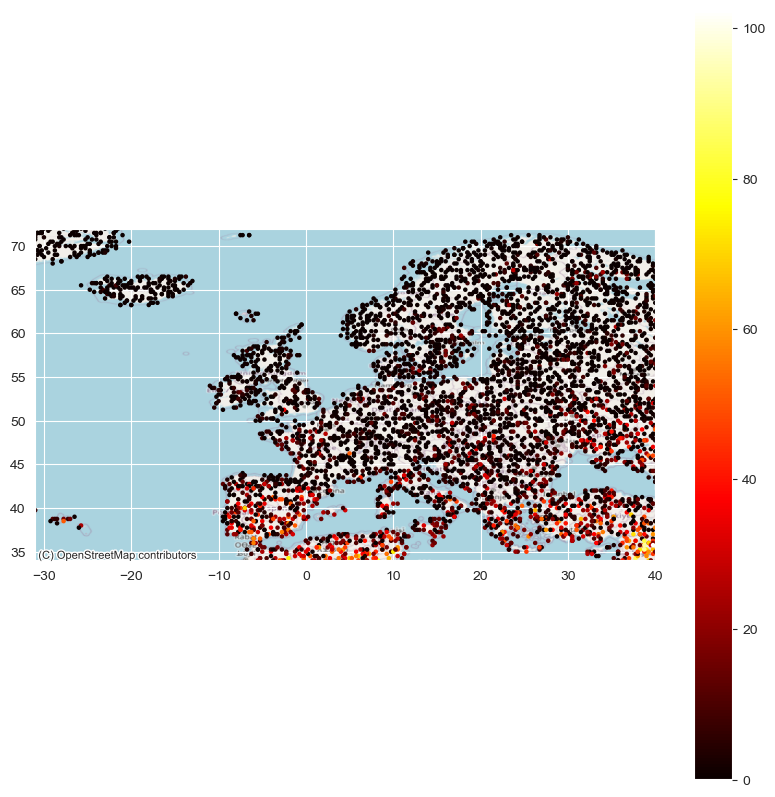

In [5]:
import contextily as ctx
import matplotlib.pyplot as plt

geo_bound_eu = (-31, 34, 40 ,72)
fig, ax = plt.subplots(figsize=(10, 10))
df_false.plot(ax=ax, column='fwi', legend=True, cmap='hot', markersize=5)
ax.set_xlim(geo_bound_eu[0], geo_bound_eu[2])
ax.set_ylim(geo_bound_eu[1], geo_bound_eu[3])
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

### Map land cover to fire ignition probability

In [12]:
# Map land cover type to ignition probability according to Climada Master thesis Table 2.1
# and Land Cover User Manual Table 4 Discrete classification coding
land_cover_map_dict = {
    0: 0, # no input data
    111: 1, 113: 1, 112: 1, 114: 1, 115: 1, 116: 1, 121: 1, 123: 1, 122: 1, 124: 1, 125: 1, 126: 1, # forest
    20: 1, # shrubs
    30: 1, # Herbaceous vegetation
    90: 0.85, # Herbaceous wetland
    100: 1, # Moss and lichen
    60: 0, # Bare / sparse vegetation
    40: 0, # cropland
    50: 0, # Urban / built up
    70: 0, # Snow and ice
    80: 0, # permanent water bodies 
    200: 0, # open sea
}

df['land_cover'] = df['land_cover'].map(land_cover_map_dict)
df['land_cover'].value_counts()

land_cover
0.00    111912
1.00     46673
0.85      1068
Name: count, dtype: int64

In [7]:
# Update: 255 is not in the land cover map anymore
# can't find information for id = 255 in https://zenodo.org/records/4723921
# therefore replace it with mean value
# df['land_cover'].fillna(df['land_cover'].mean(), inplace=True)

In [14]:
df.rename(columns={'land_cover': 'ignition_probability'}, inplace=True)

### Only retain month for date column then take sin and cos

In [15]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the month from the 'date' column
df['month'] = df['date'].dt.month

In [16]:
print(df['month'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [17]:
# Create 'month_sin' and 'month_cos' columns
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df = df.drop(columns=['month', 'date', 'distance_km', 'confidence', 'geometry'])

### Make sure there is no NA values

In [18]:
df.isna().sum()

latitude                    0
longitude                   0
brightness                  0
bright_t31                  0
fwi                     42959
ignited                     0
ignition_probability        0
elevation                   0
month_sin                   0
month_cos                   0
dtype: int64

In [19]:
df['fwi'].fillna(0, inplace=True)

## Training ML models with Optuna optimization and Cross Validation

In [20]:
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

### Train test split

In [21]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop(columns=['ignited']), df['ignited'], test_size=0.1, random_state=42, shuffle=True)

In [22]:
print(X_train_val.shape, X_test.shape)

(143687, 9) (15966, 9)


### Hyperparameter tuning with Optuna and cross validation

In [23]:


classifier_names = ["LogisticRegression", "XGBClassifier"]

# Create dictionaries to store the best models, hyperparameters, and scores for each ML model
best_models = {}
best_params = {}
best_scores = {}

for name in classifier_names:
    best_scores[name] = 0
    best_params[name] = None
    best_models[name] = None

In [24]:
# function for both Logistic Regression and XGBoost
# Should use normalized data for training and testing for Logistic Regression. To be implemented in the future.
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', classifier_names)
    if classifier_name == "LogisticRegression":
        logistic_c = trial.suggest_float('logistic_c', 1e-5, 1e5, log=True)
        classifier_obj = LogisticRegression(C=logistic_c, random_state=42)
    elif classifier_name == "XGBClassifier":
        xgb_params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
            'subsample': trial.suggest_float('subsample', 0.2, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
            'random_state': 42
        }
        classifier_obj = XGBClassifier(**xgb_params)
    else:
        raise ValueError("Invalid classifier name")

    # Perform cross-validation
    score = cross_val_score(classifier_obj, X_train_val, y_train_val, cv=5, n_jobs=-1, scoring='accuracy').mean() # scoring='roc_auc'
    
    if score > best_scores[classifier_name]:
        best_scores[classifier_name] = score
        best_params[classifier_name] = trial.params
        best_models[classifier_name] = classifier_obj # classifier_obj remain untrained
        
    return score
    

In [25]:
study = optuna.create_study(sampler=optuna.samplers.GPSampler(), storage='sqlite:///db.sqlite3', direction='maximize')
study.optimize(objective, n_trials=100)

C:\Users\zhong\AppData\Local\Temp\ipykernel_21644\1077857829.py:1: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = optuna.create_study(sampler=optuna.samplers.GPSampler(), storage='sqlite:///db.sqlite3', direction='maximize')
[I 2024-07-09 16:14:03,818] A new study created in RDB with name: no-name-6ebe2064-596b-42aa-af1d-30d1d5719ea4
[I 2024-07-09 16:14:05,684] Trial 0 finished with value: 0.8272216645744674 and parameters: {'classifier': 'LogisticRegression', 'logistic_c': 1.1622676661267817}. Best is trial 0 with value: 0.8272216645744674.
[I 2024-07-09 16:14:11,247] Trial 1 finished with value: 0.934078925563931 and parameters: {'classifier': 'XGBClassifier', 'n_estimators': 608, 'max_depth': 4, 'learning_rate': 0.054499343011690106, 'subsample': 0.3992326309690246, 'colsample_bytree': 0.7038405183884633, 'gamma': 3.7479377272591288, 'reg_alpha': 0.4737959967365539, 'reg_lambda': 0.7338335779132353}. Best is 

### Training accuracy, Test accuracy and F-1 score

In [28]:
# Run this code if you need to rerun training and test accuracy
# for name in classifier_names:
#     if name == 'XGBClassifier':
#         model = XGBClassifier(**best_params[name], random_state=42)
#     elif name == 'LogisticRegression':
#         model = LogisticRegression(C=best_params[name]['logistic_c'], random_state=42)
#     else:
#         raise ValueError("Invalid classifier name")

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

for name in classifier_names:
    print("Model:", name)
    print("Best hyperparameters:", best_params[name])
    
    if name == "LogisticRegression":
        # Increase max_iter in the LogisticRegression model
        best_models[name].set_params(max_iter=200)
        
        # Create a pipeline with a scaler and the updated model
        model_pipeline = make_pipeline(StandardScaler(), best_models[name])
    else:
        model_pipeline = best_models[name]

    # Fit the best model on the training data
    model_pipeline.fit(X_train_val, y_train_val)
    
    # Calculate the training accuracy
    train_accuracy = model_pipeline.score(X_train_val, y_train_val)
    print("Training accuracy:", train_accuracy)
    test_accuracy = model_pipeline.score(X_test, y_test)
    print("Test accuracy:", test_accuracy)
    y_pred = model_pipeline.predict(X_test)
    # Print the classification report
    print(classification_report(y_test, y_pred))
    # Print the confusion matrix
    print(confusion_matrix(y_test, y_pred))

Model: LogisticRegression
Best hyperparameters: {'classifier': 'LogisticRegression', 'logistic_c': 0.00010300681972133285}
Training accuracy: 0.8192947169890108
Test accuracy: 0.8197419516472504
              precision    recall  f1-score   support

       False       0.83      0.84      0.84      8733
        True       0.81      0.79      0.80      7233

    accuracy                           0.82     15966
   macro avg       0.82      0.82      0.82     15966
weighted avg       0.82      0.82      0.82     15966

[[7353 1380]
 [1498 5735]]
Model: XGBClassifier
Best hyperparameters: {'classifier': 'XGBClassifier', 'n_estimators': 1721, 'max_depth': 7, 'learning_rate': 0.06314229367604507, 'subsample': 0.8902965982602855, 'colsample_bytree': 0.546548320837359, 'gamma': 0.20261497991138244, 'reg_alpha': 0.1028908930873037, 'reg_lambda': 0.5618255468671847}
Training accuracy: 0.9925254198361717
Test accuracy: 0.9654265313791808
              precision    recall  f1-score   support

    

### Feature importance

In [34]:
classifier_names

['LogisticRegression', 'XGBClassifier']

In [36]:
for name in classifier_names:
    if name == "LogisticRegression":
        reg_coff = best_models[name].coef_[0]
        feature_importance_df = pd.DataFrame({'feature': X_train_val.columns, 'coefficient': reg_coff})
        feature_importance_df = feature_importance_df.sort_values(by='coefficient', ascending=False)
        print(name)
        print(feature_importance_df)
        print('------------------------------------')
    elif name == "XGBClassifier":
        feature_importance = best_models[name].feature_importances_
        feature_importance_df = pd.DataFrame({'feature': X_train_val.columns, 'importance': feature_importance})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
        print(name)
        print(feature_importance_df)
        print('------------------------------------')

LogisticRegression
                feature  coefficient
1             longitude     0.709482
4                   fwi     0.667891
3            bright_t31     0.306659
2            brightness     0.077673
5  ignition_probability     0.040754
7             month_sin     0.012813
6             elevation    -0.037936
8             month_cos    -0.137747
0              latitude    -0.312795
------------------------------------
XGBClassifier
                feature  importance
4                   fwi    0.213571
6             elevation    0.209176
0              latitude    0.142960
5  ignition_probability    0.141978
1             longitude    0.085986
8             month_cos    0.065002
7             month_sin    0.064598
3            bright_t31    0.053938
2            brightness    0.022792
------------------------------------


Logistic Regression calculates feature importance based on the coefficients assigned to each feature. These coefficients represent the change in the log odds of the outcome for a one-unit change in the feature. Features with larger absolute coefficients are considered more important. This method is linear and assumes a direct relationship between the feature and the outcome.  

XGBoost, on the other hand, uses an ensemble of decision trees. It calculates feature importance as the gain, which measures the contribution of each feature to the model's performance. The importance can be based on how often a feature is used to split the data across all trees (frequency), the total gain of splits which use the feature (gain), or the average gain of splits which use the feature (average gain). This method captures non-linear relationships and interactions between features.  

Given these differences, Logistic Regression might prioritize features that have a strong linear relationship with the outcome, while XGBoost might highlight features that are more critical in terms of interaction with other features or in splitting the data in complex, non-linear ways. This discrepancy is especially common in datasets where relationships between features and the target variable are not strictly linear or when features interact with each other in complex ways.

# 5. Visualization

In [38]:
df_sub = df.sample(n=10000, replace=False)

In [40]:
df_sub.isna().sum()

latitude                0
longitude               0
brightness              0
bright_t31              0
fwi                     0
ignited                 0
ignition_probability    0
elevation               0
month_sin               0
month_cos               0
dtype: int64

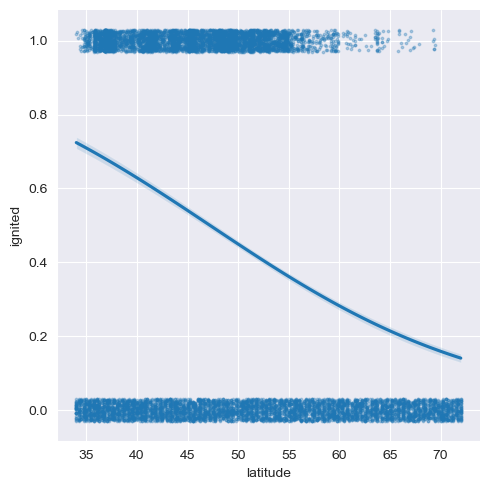

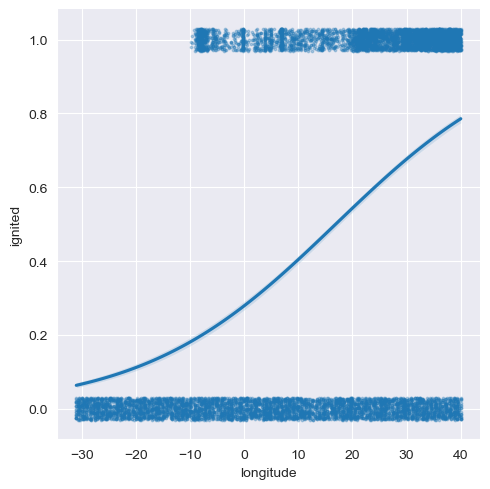

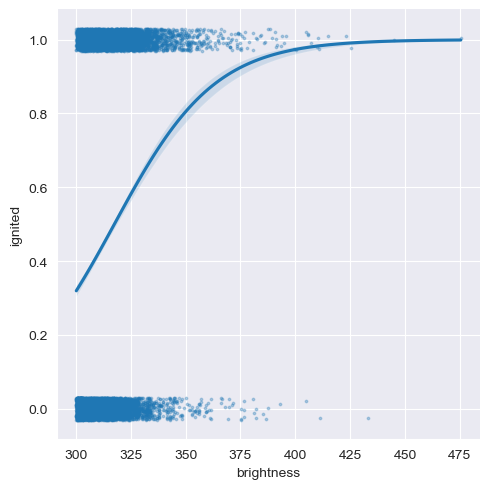

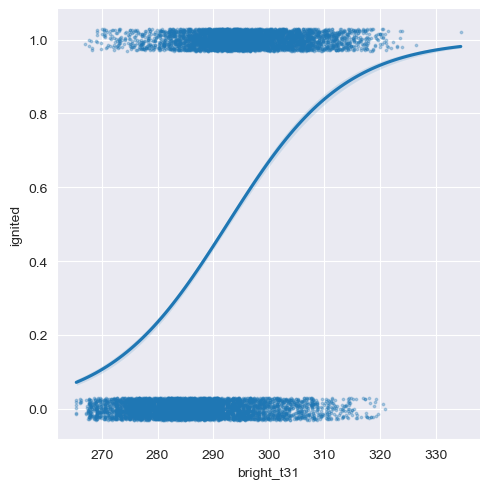

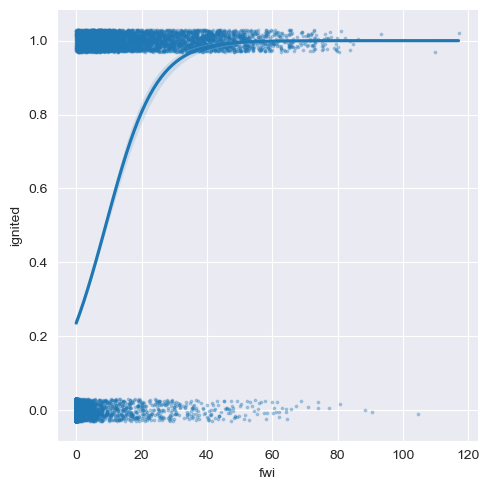

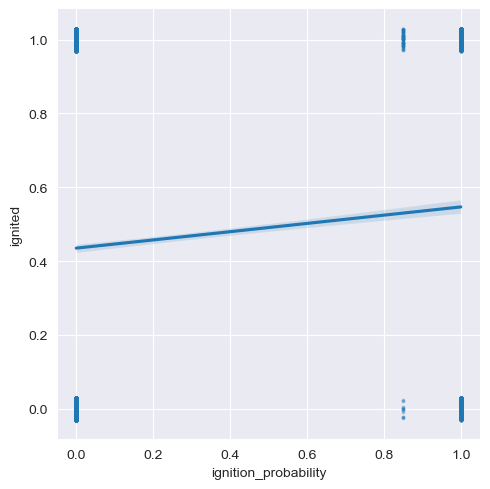

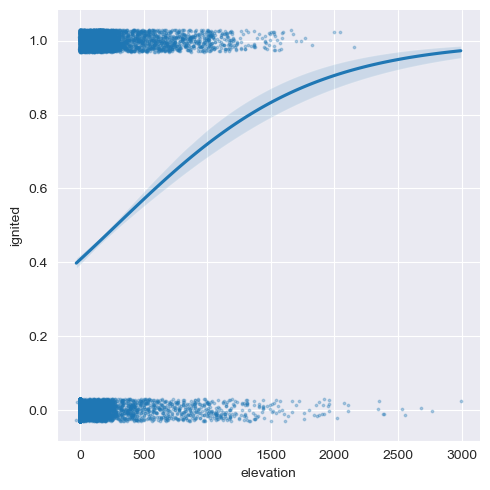

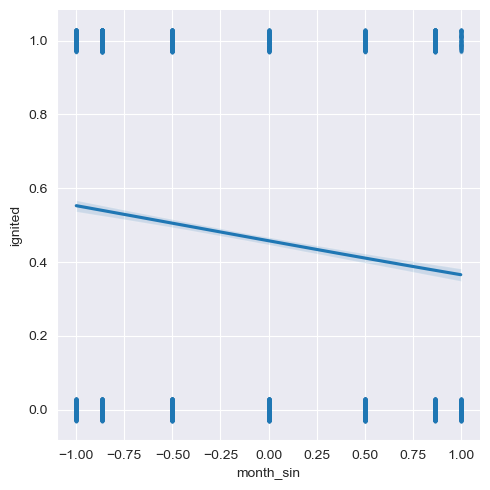

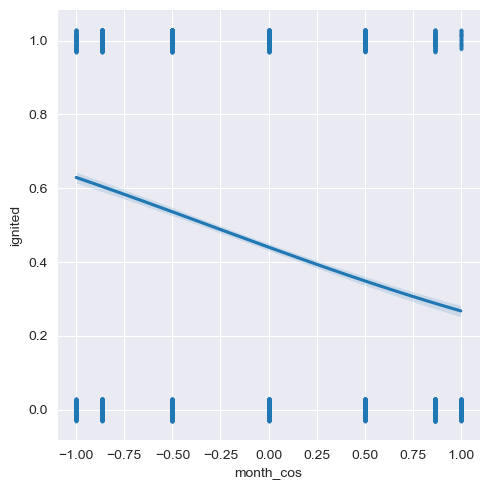

In [44]:
import seaborn as sns
for col in df.columns:
    if col != 'ignited':
        sns.lmplot(x=col, y='ignited', data=df_sub, logistic=True, y_jitter=0.03, scatter_kws={'alpha': 0.3, 's': 3})
        plt.show()

In [48]:
correlation_matrix = df.corr()
correlation_matrix

,latitude,longitude,brightness,bright_t31,fwi,ignited,ignition_probability,elevation,month_sin,month_cos
latitude,1.000000,-0.076478,-0.259527,-0.488203,-0.462664,-0.336513,0.024988,-0.276405,0.188376,0.035862
longitude,-0.076478,1.000000,0.061420,0.173126,0.274553,0.455308,0.165127,0.185360,0.014310,-0.115544
brightness,-0.259527,0.061420,1.000000,0.530080,0.428767,0.250383,0.046641,0.139596,-0.208657,-0.245357
bright_t31,-0.488203,0.173126,0.530080,1.000000,0.587817,0.428747,-0.006562,0.199262,-0.348061,-0.500004
fwi,-0.462664,0.274553,0.428767,0.587817,1.000000,0.527461,0.123101,0.357226,-0.349428,-0.298799
ignited,-0.336513,0.455308,0.250383,0.428747,0.527461,1.000000,0.091349,0.171922,-0.136972,-0.239921
ignition_probability,0.024988,0.165127,0.046641,-0.006562,0.123101,0.091349,1.000000,0.374097,0.033665,-0.052752
elevation,-0.276405,0.185360,0.139596,0.199262,0.357226,0.171922,0.374097,1.000000,-0.118798,-0.019143
month_sin,0.188376,0.014310,-0.208657,-0.348061,-0.349428,-0.136972,0.033665,-0.118798,1.000000,-0.055857
month_cos,0.035862,-0.115544,-0.245357,-0.500004,-0.298799,-0.239921,-0.052752,-0.019143,-0.055857,1.000000


<Axes: >

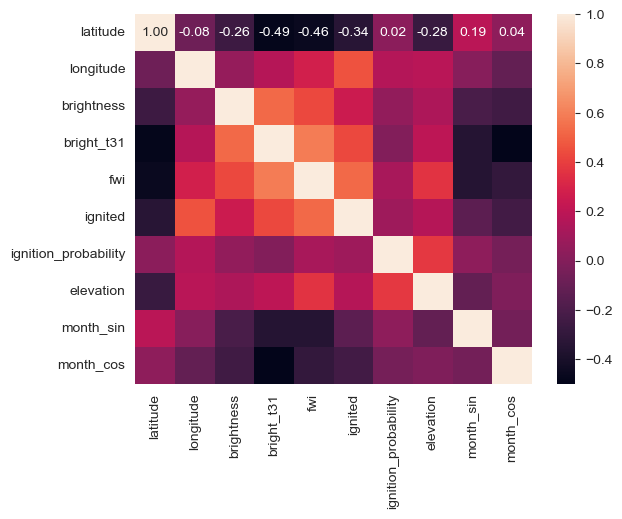

In [45]:
sns.heatmap(df.corr(), annot=True, fmt=".2f")